In [26]:
import xarray as xr
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from specutils import Spectrum
from specutils.analysis import correlation
from scipy.optimize import curve_fit
from specutils.fitting import fit_generic_continuum
from scipy.interpolate import interp1d
from astropy.nddata import StdDevUncertainty

In [27]:
def correlation(spec1, spec2):
    """
    Performs cross-correlation of two spectra and normalizes the output.
    """
    # Ensure the spectra have the same length for correlation
    min_len = min(len(spec1.flux), len(spec2.flux))
    flux1 = spec1.flux.value[:min_len]
    flux2 = spec2.flux.value[:min_len]

    # Perform cross-correlation
    corr = np.correlate(flux1, flux2, mode='full')
    lags = np.arange(-min_len + 1, min_len)
    
    # Calculate the normalization factor
    # This is the product of the L2 norms (magnitudes) of the two arrays
    norm_factor = np.sqrt(np.sum(flux1**2) * np.sum(flux2**2))
    
    # Normalize the correlation array
    normalized_corr = corr / norm_factor
    
    return normalized_corr, lags

def polynomial_degree_n(x, *coefficients):
    """A helper function to create a polynomial of a given degree."""
    return sum(coefficients[i] * x**i for i in range(len(coefficients)))

def calculate_bic(ssr, N, k):
    """Calculates the Bayesian Information Criterion (BIC)."""
    if N == 0:
        return np.inf
    return N * np.log(ssr / N) + k * np.log(N)

def bic_continuum_fit(spectrum, max_order=5, exclusion_ranges=None):
    """
    Fits a continuum to a spectrum by selecting the best polynomial order
    based on BIC.

    Parameters:
    - spectrum: A Spectrum1D object containing the data.
    - max_order: The maximum polynomial order to test.
    - exclusion_ranges: A list of tuples, e.g., [(start1, end1), (start2, end2)],
                        specifying wavelength ranges to exclude from the fit.

    Returns:
    - A Spectrum1D object representing the best-fit continuum.
    """
    wavelength = spectrum.spectral_axis
    flux = spectrum.flux
    
    if exclusion_ranges:
        mask = np.ones(wavelength.shape, dtype=bool)
        for start, end in exclusion_ranges:
            mask &= ~((wavelength >= start) & (wavelength <= end))
    else:
        mask = np.ones(wavelength.shape, dtype=bool)

    x = wavelength[mask].value
    y = flux[mask].value

    best_bic = np.inf
    best_popt = None
    best_order = 0

    for n in range(max_order + 1):
        try:
            def current_poly(x, *coeffs):
                return polynomial_degree_n(x, *coeffs)

            popt, pcov = curve_fit(current_poly, x, y, p0=np.zeros(n + 1), maxfev=50000)
            
            y_fit = current_poly(x, *popt)
            residuals = y - y_fit
            ssr = np.sum(residuals ** 2)
            N = len(y)
            k = len(popt)
            bic = calculate_bic(ssr, N, k)

            if bic < best_bic:
                best_bic = bic
                best_popt = popt
                best_order = n

        except RuntimeError as e:
            print(f"Fit for order {n} failed: {e}")
            continue

    if best_popt is not None:
        def best_poly(x, *coeffs):
            return polynomial_degree_n(x, *coeffs)
        
        continuum_flux = best_poly(wavelength.value, *best_popt) * flux.unit
        return Spectrum(spectral_axis=wavelength, flux=continuum_flux)
    else:
        # Return a flat continuum with units if all fits fail
        continuum_flux = np.full_like(wavelength.value, np.nan) * flux.unit
        return Spectrum(spectral_axis=wavelength, flux=continuum_flux)

In [28]:
ds = xr.open_dataset("D:/Pavlicek, Emma/SDSS1411/SDSS1411_spectra.nc")

wavelength = ds.wavelength.values * u.AA

# Flux and uncertainty arrays
flux_array = ds.flux_calibrated.values * u.Unit('')  # shape (n_spectra, n_wavelengths)
flux_err_array = ds.flux_calibrated_error.values * u.Unit('')

time_seconds = ds.time.values
num_spectra = flux_array.shape[0]

# --- Build Spectrum objects with uncertainties ---
spectra = []
for i in range(num_spectra):
    spec = Spectrum(
        spectral_axis=wavelength,
        flux=flux_array[i, :],
        uncertainty=StdDevUncertainty(flux_err_array[i, :])  # keep errors for weighting
    )
    spectra.append(spec)

In [ ]:
#OLDEST VERSION
reference_spectrum = spectra[0]
reference_flux = reference_spectrum.flux.value
reference_flux = reference_flux - np.mean(reference_flux)

c = 299792.458  # km/s
wavelength = reference_spectrum.spectral_axis.value
delta_lambda = wavelength[1] - wavelength[0]   # spacing per pixel
lambda0 = np.median(wavelength)                # central wavelength

velocity_shifts = []

for i in range(num_spectra):
    target = spectra[i]
    flux = target.flux.value - np.mean(target.flux.value)
    ref_flux = reference_spectrum.flux.value - np.mean(reference_spectrum.flux.value)

    target_norm = Spectrum(flux=flux * target.flux.unit,
                             spectral_axis=target.spectral_axis)
    ref_norm = Spectrum(flux=ref_flux * reference_spectrum.flux.unit,
                          spectral_axis=reference_spectrum.spectral_axis)

    ccf_flux, ccf_lag = correlation.template_correlate(
        target_norm, ref_norm,
        lag_units=u.dimensionless_unscaled,
        resample=False,
        method='FFT'
    )

    ccf_flux = ccf_flux / (np.linalg.norm(flux) * np.linalg.norm(ref_flux))

    # Find peak lag
    peak_index = np.argmax(ccf_flux)
    pixel_lag = ccf_lag[peak_index].value

    # Convert to km/s
    velocity_shift = pixel_lag * delta_lambda / lambda0 * c
    velocity_shifts.append(velocity_shift)

    plt.plot(ccf_lag.value * delta_lambda / lambda0 * c,  # x-axis in km/s
             ccf_flux.value, label=f"Spectrum {i}")

plt.xlabel("Velocity Lag (km/s)")
plt.ylabel("Normalized Cross-Correlation")
plt.title("Cross-Correlation of All Spectra vs. Reference Spectrum")
plt.grid(True)
plt.legend()
plt.show()

print("Radial velocity shifts (km/s):")
print(velocity_shifts)


# Plot the results.
plt.figure(figsize=(10, 6))
plt.plot(time_seconds, velocity_shifts, 'o-')
plt.xlabel("Minutes since start")
plt.ylabel("Radial Velocity Shift (Redshift)")
plt.title("Radial Velocity Curve (All Indices)")
plt.grid(True)
plt.show()


In [ ]:
#masking?
# --- Define Gaussian model ---
def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset

# --- Setup ---
c = 299792.458  # km/s
all_fluxes = [spec.flux.value for spec in spectra]  # list of flux arrays
wavelength = spectra[0].spectral_axis.value         # wavelength grid (assume same for all)
delta_lambda = np.median(np.diff(wavelength))       # dispersion [Å/pixel]
lambda0 = np.median(wavelength)                     # reference λ [Å]

reference_flux = all_fluxes[0]  # first spectrum as template
velocity_shifts = []

# Defining telluric regions
telluric_regions = [(3200, 3770), (5500, 5700)] 

# Create a mask for the entire spectrum
full_mask = np.ones_like(wavelength, dtype=bool)

# Apply masks for telluric regions
for start, end in telluric_regions:
    full_mask[(wavelength >= start) & (wavelength <= end)] = False

# --- Loop over spectra ---
for i, flux in enumerate(all_fluxes):
    masked_flux = flux[full_mask]
    masked_reference_flux = reference_flux[full_mask]

    # Cross-correlation
    ccf = np.correlate(masked_flux - np.mean(masked_flux),
                    masked_reference_flux - np.mean(masked_reference_flux),
                       mode="full")
    lags = np.arange(-len(masked_flux) + 1, len(masked_flux))
    
    # Normalize
    ccf = ccf / (np.linalg.norm(masked_flux - np.mean(masked_flux)) *
                 np.linalg.norm(masked_reference_flux - np.mean(masked_reference_flux)))

    # Convert lag → velocity
    velocity_axis = lags * delta_lambda / lambda0 * c

    # --- Gaussian fit near peak ---
    peak_index = np.argmax(ccf)
    peak_vel = velocity_axis[peak_index]

    # Fit window in velocity space
    fit_width = 150  # km/s around peak
    mask_fit = (velocity_axis > peak_vel - fit_width) & (velocity_axis < peak_vel + fit_width)
    xdata = velocity_axis[mask_fit]
    ydata = ccf[mask_fit]

    # Initial guess [amp, mu, sigma, offset]
    p0 = [ydata.max(), peak_vel, 30.0, np.median(ydata)]

    # Bounds: amp>0, mu near peak, sigma reasonable
    bounds = (
        [0.0, peak_vel - 100, 5.0, -np.inf],
        [1.5 * ydata.max(), peak_vel + 100, 200.0, np.inf]
    )

    try:
        popt, _ = curve_fit(gaussian, xdata, ydata, p0=p0, bounds=bounds, maxfev=5000)
        rv_shift = popt[1]

        # sanity check: if fit peak is too far from pixel max, fallback
        if abs(rv_shift - peak_vel) > 80:
            rv_shift = peak_vel
    except RuntimeError:
        rv_shift = peak_vel

    velocity_shifts.append(rv_shift)

    # --- Diagnostic plot (zoom ±200 km/s) ---
    zoom = 200
    mask = (velocity_axis > -zoom) & (velocity_axis < zoom)
    plt.figure(figsize=(8, 5))
    plt.plot(velocity_axis[mask], ccf[mask], label="CCF", color="C0")
    plt.axvline(velocity_axis[peak_index], color="r", linestyle="--", label="Max pixel lag")

    if 'popt' in locals():
        xfit = np.linspace(xdata.min(), xdata.max(), 200)
        yfit = gaussian(xfit, *popt)
        plt.plot(xfit, yfit, "k--", label="Gaussian fit")
        plt.axvline(popt[1], color="g", linestyle="--", label="Gaussian peak")

    plt.xlabel("Velocity shift (km/s)")
    plt.ylabel("CCF (normalized)")
    plt.title(f"Cross-Correlation Spectrum {i}")
    plt.legend()
    plt.grid(True)
    plt.show()
    

# --- Print results ---
print("Radial velocity shifts (km/s):", velocity_shifts)
print("Peak-to-peak (km/s):", np.ptp(velocity_shifts))
print("Semi-amplitude K (km/s):", np.ptp(velocity_shifts) / 2)


velocity_shifts = np.array(velocity_shifts)


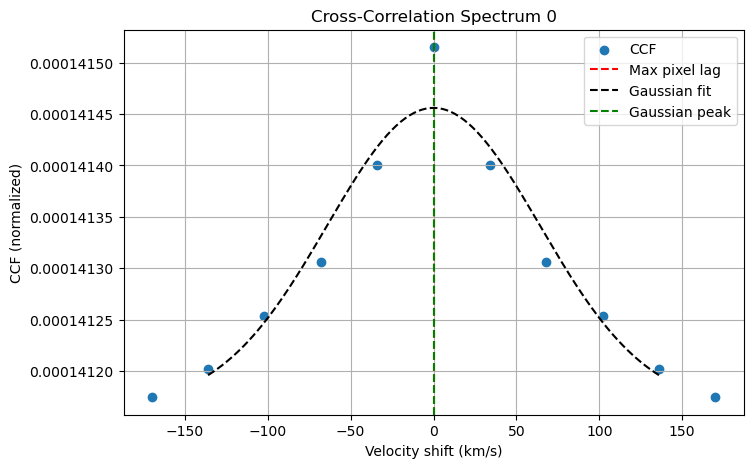

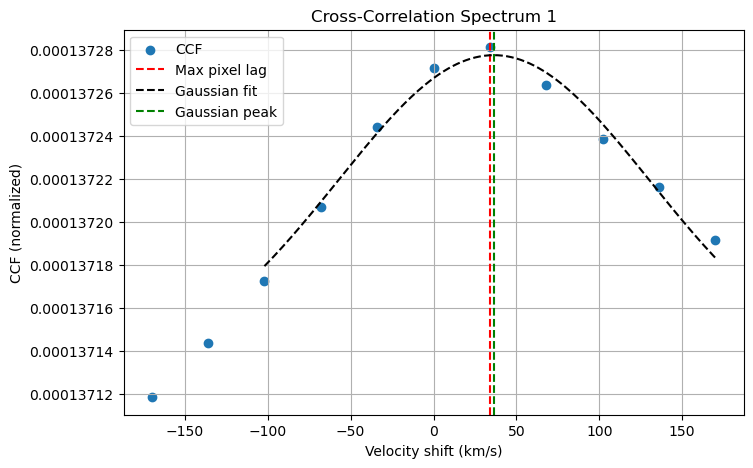

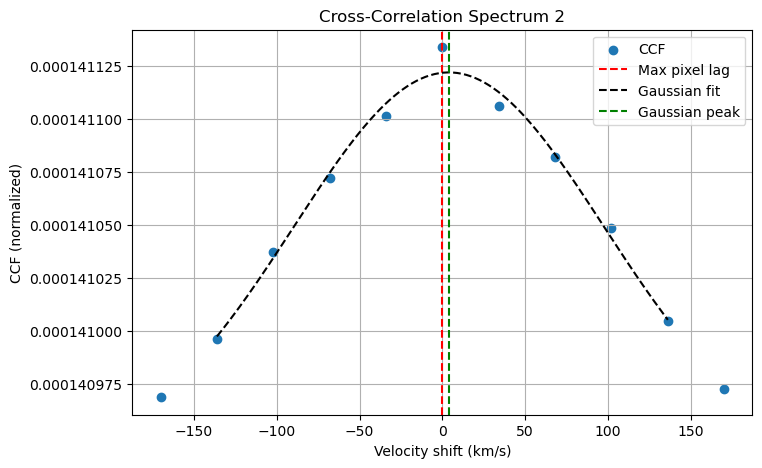

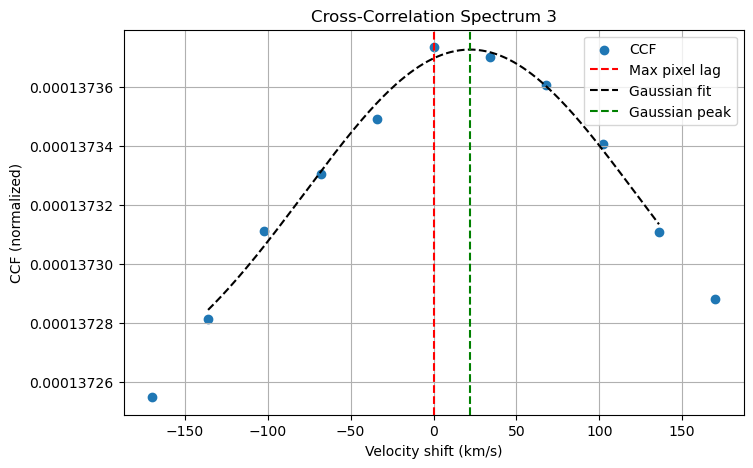

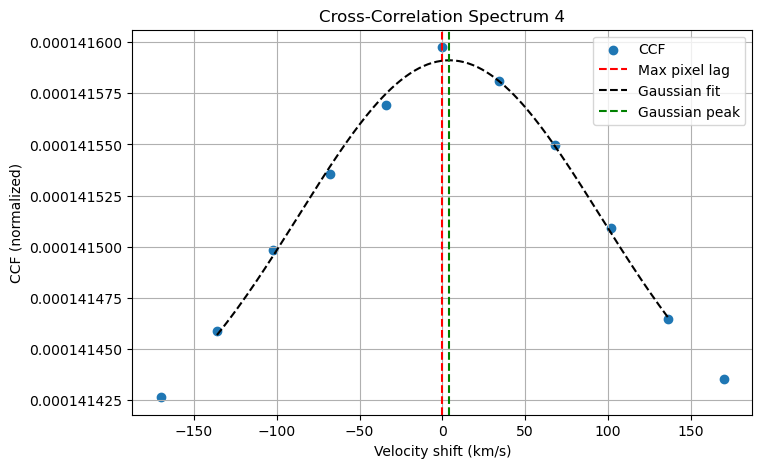

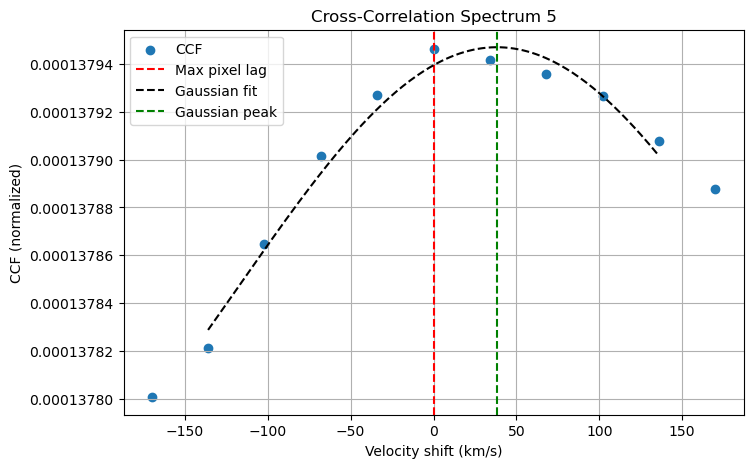

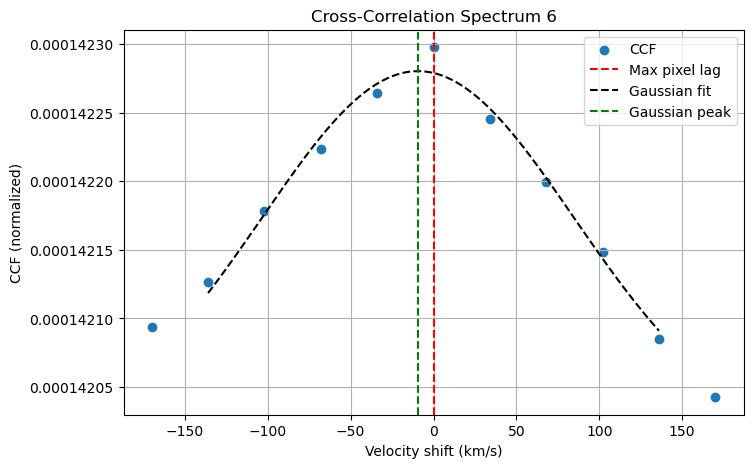

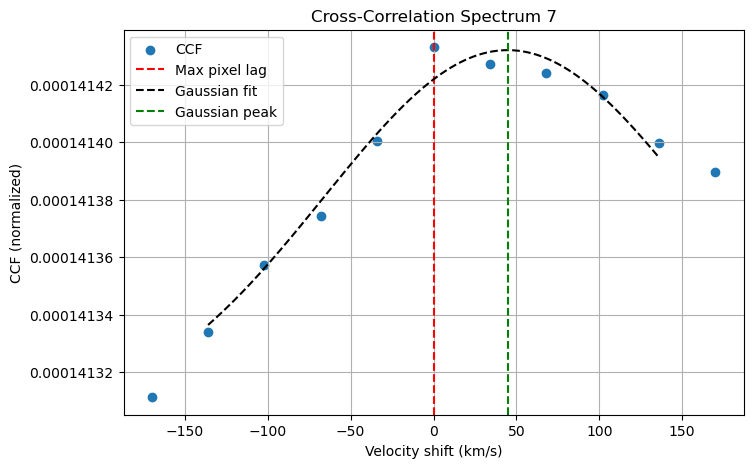

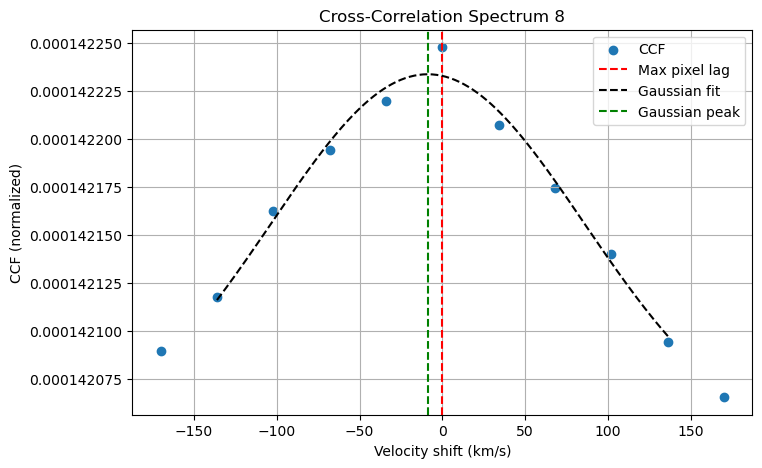

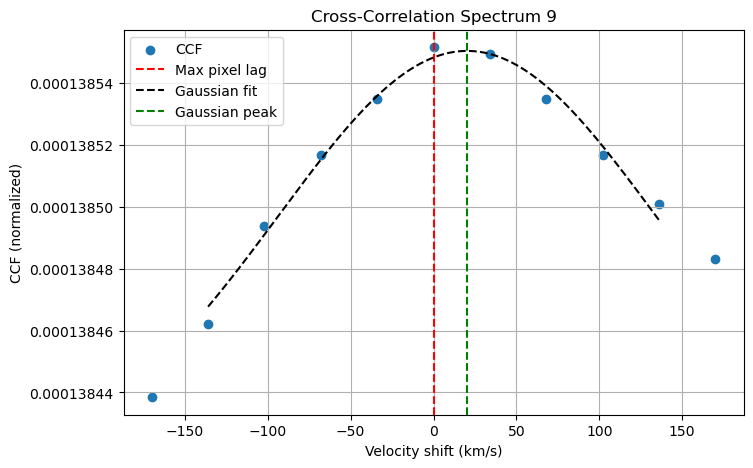

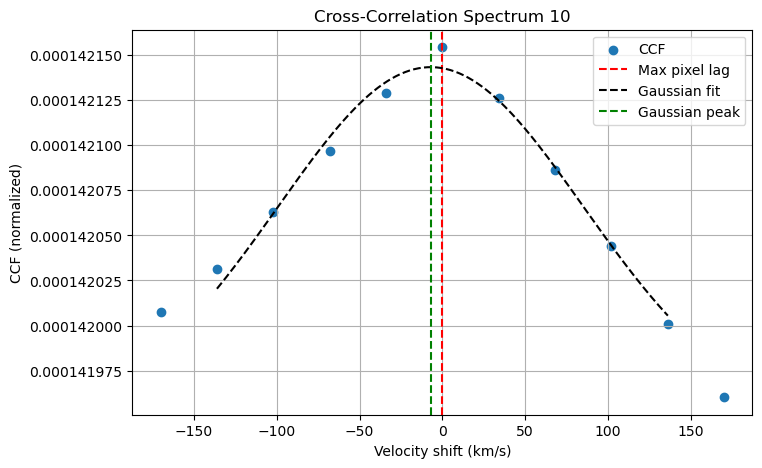

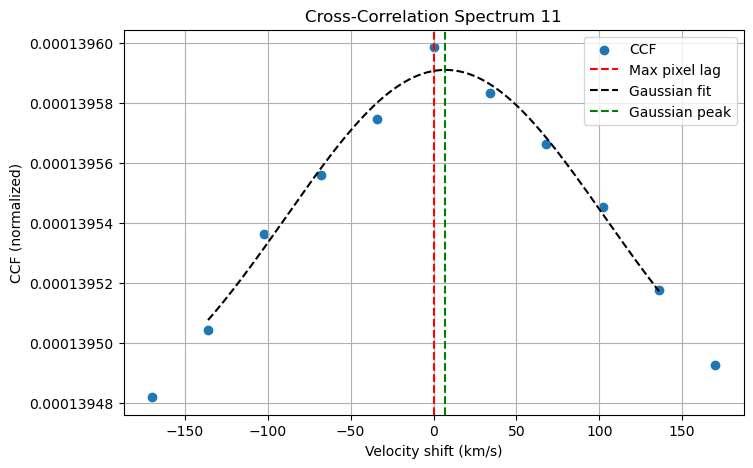

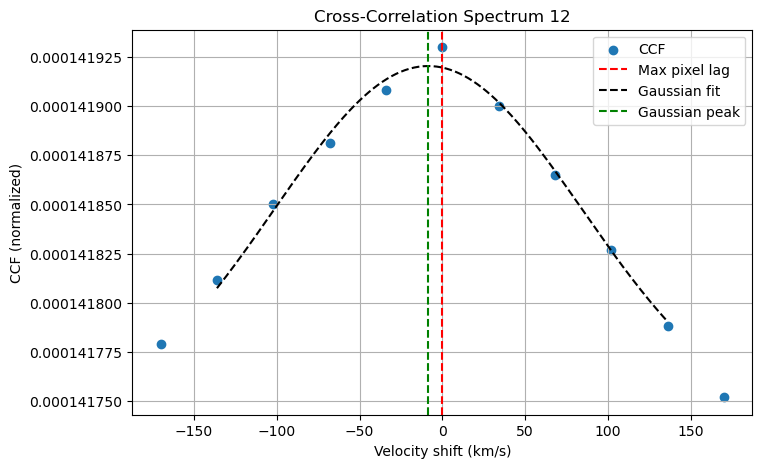

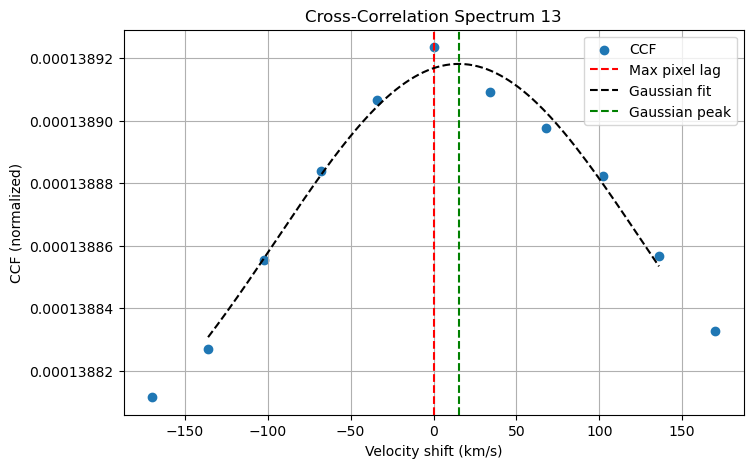

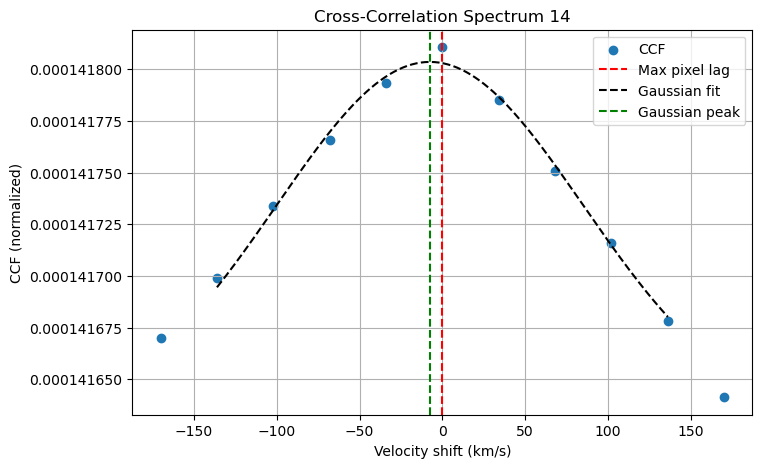

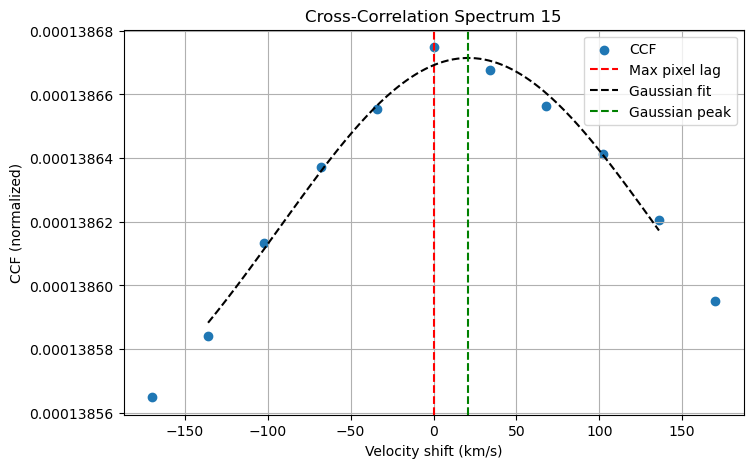

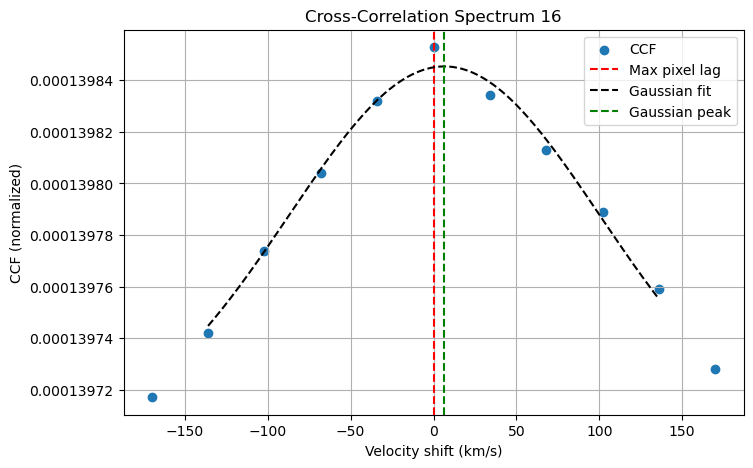

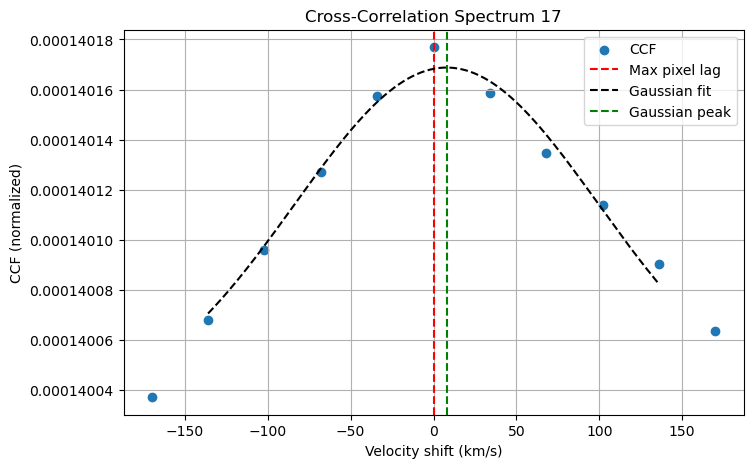

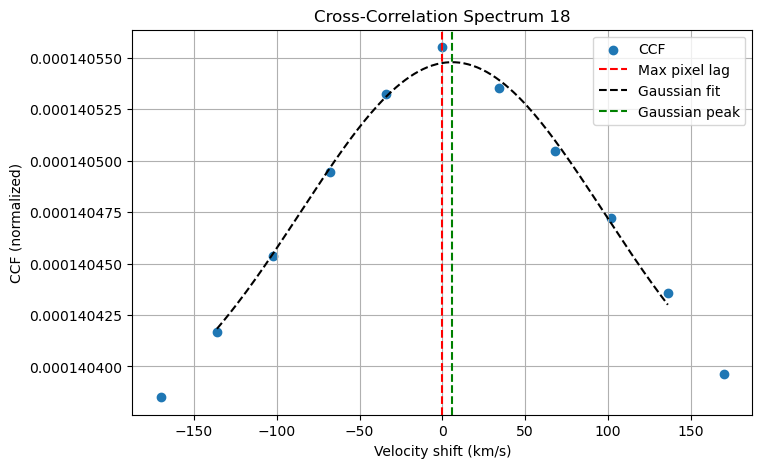

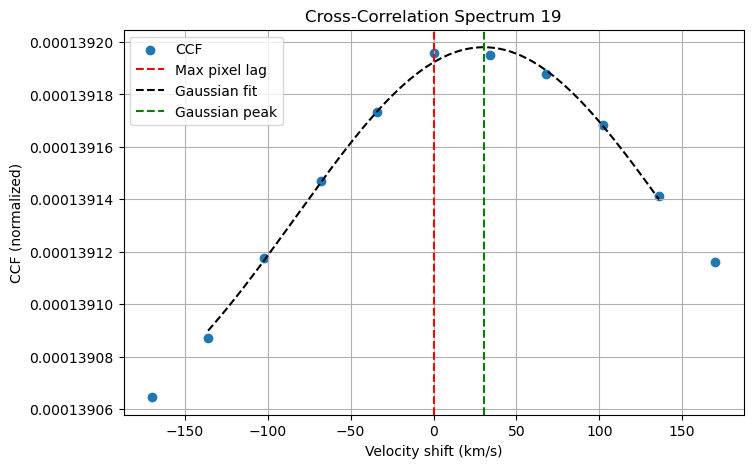

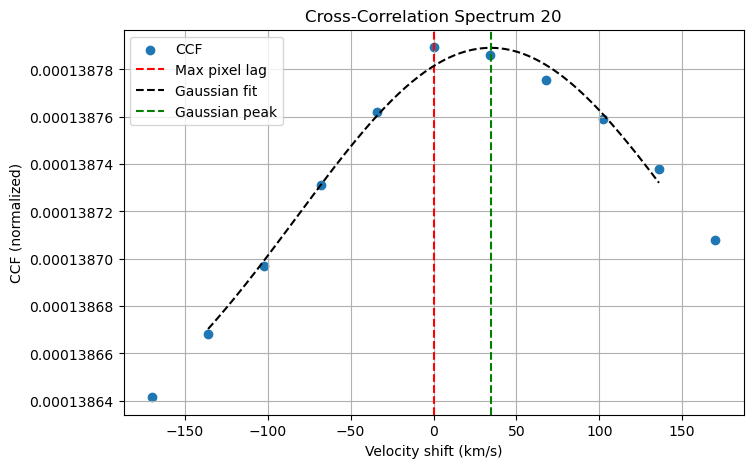

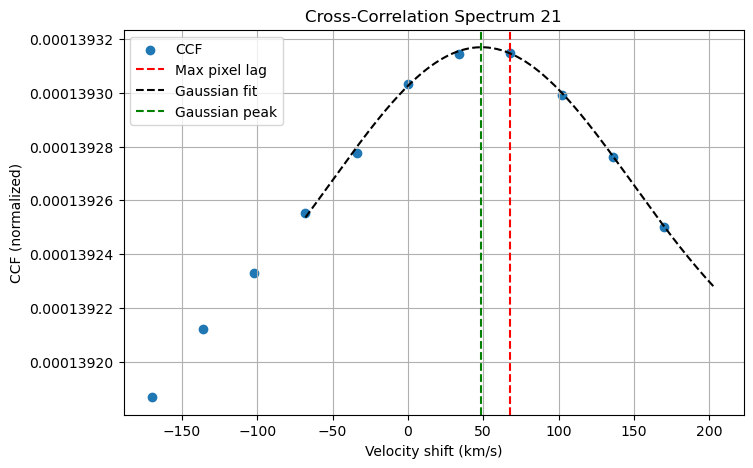

Peak-lag velocities (km/s): [ 0.         33.99785529  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         67.99571057]
Gaussian-fit velocities (km/s): [-1.12134594e-03  3.64046431e+01  3.92028204e+00  2.20104711e+01
  4.19806164e+00  3.82145691e+01 -9.36560693e+00  4.47498237e+01
 -8.84297737e+00  2.02544531e+01 -7.03754608e+00  7.17427894e+00
 -8.57406947e+00  1.52166891e+01 -7.54643645e+00  2.09462308e+01
  6.55449159e+00  7.90207448e+00  5.87165310e+00  3.02743159e+01
  3.44699929e+01  4.87904830e+01]
Peak-to-peak (peak-lag): 67.99571057092469
Semi-amplitude K (peak-lag): 33.99785528546234
Peak-to-peak (gaussian): 58.15608990538458
Semi-amplitude K (gaussian): 29.07804495269229


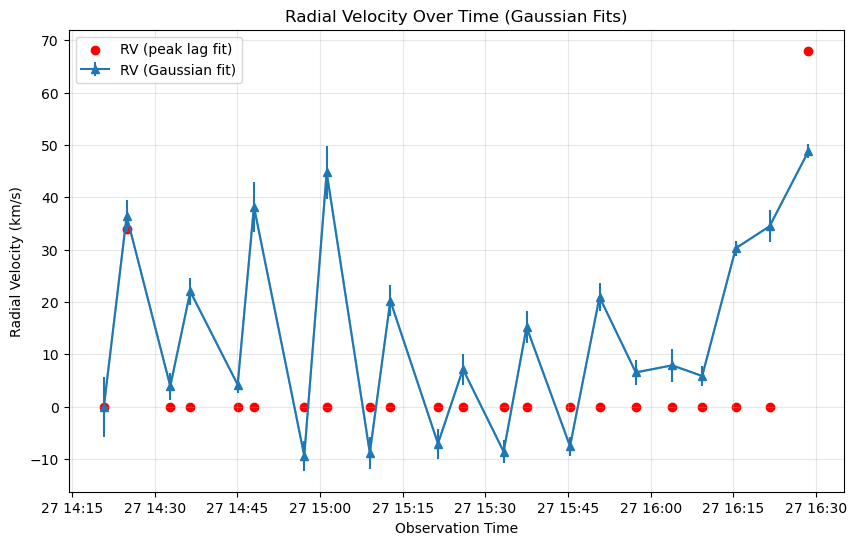

In [29]:
# --- Define Gaussian model ---
def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset

c = 299792.458  # km/s

# --- Setup: define a common log-wavelength grid ---
wavelength_native = spectra[0].spectral_axis.value
lnlam = np.log(wavelength_native)
delta_ln = np.median(np.diff(lnlam))
log_wave_grid = np.exp(np.linspace(lnlam.min(), lnlam.max(), len(wavelength_native)))

# Resample all spectra onto the log grid
all_fluxes = []
for spec in spectra:
    interp = interp1d(spec.spectral_axis.value, spec.flux.value,
                      kind="linear", bounds_error=False, fill_value="extrapolate")
    all_fluxes.append(interp(log_wave_grid))
all_fluxes = np.array(all_fluxes)

for flux in all_fluxes:
    flux /= np.sum(flux)

reference_flux = all_fluxes[0]
peak_velocities = []     # pixel-lag maximum estimate
gaussian_velocities = [] # Gaussian fit estimate
gaussian_errors = []

for i, flux in enumerate(all_fluxes):

    # --- CCF ---
    ccf = np.correlate(flux, reference_flux, mode="full")
    lags = np.arange(-len(flux) + 1, len(flux))
    
    velocity_axis = lags * c * delta_ln

    # --- Peak estimate ---
    peak_index = np.argmax(ccf)
    peak_vel = velocity_axis[peak_index]
    peak_velocities.append(peak_vel)

    # --- Gaussian fit ---
    fit_width = 150
    mask_fit = (velocity_axis > peak_vel - fit_width) & (velocity_axis < peak_vel + fit_width)
    xdata, ydata = velocity_axis[mask_fit], ccf[mask_fit]
    
    p0 = [(ydata.max() - ydata.min()), peak_vel, 100.0, np.median(ydata)]
    lower = [0.0, peak_vel - 100.0, 1.0, -np.inf]
    upper = [np.inf, peak_vel + 100.0, 200.0, np.inf]
    bounds = (lower, upper)

    try:
        popt, pcov = curve_fit(gaussian, xdata, ydata, p0=p0, bounds=bounds, maxfev=5000)
        gauss_vel = popt[1]
        gauss_err = np.sqrt(np.diag(pcov))
    except RuntimeError:
        gauss_vel = np.nan  # mark failed fits as NaN
        gauss_err = np.nan
    gaussian_velocities.append(gauss_vel)
    gaussian_errors.append(gauss_err)
    # --- Diagnostic plot ---
    zoom = 200
    mask = (velocity_axis > -zoom) & (velocity_axis < zoom)
    plt.figure(figsize=(8, 5))
    plt.scatter(velocity_axis[mask], ccf[mask], label="CCF", color="C0")
    plt.axvline(peak_vel, color="r", linestyle="--", label="Max pixel lag")
    if not np.isnan(gauss_vel):
        xfit = np.linspace(xdata.min(), xdata.max(), 200)
        yfit = gaussian(xfit, *popt)
        plt.plot(xfit, yfit, "k--", label="Gaussian fit")
        plt.axvline(gauss_vel, color="g", linestyle="--", label="Gaussian peak")
    plt.xlabel("Velocity shift (km/s)")
    plt.ylabel("CCF (normalized)")
    plt.title(f"Cross-Correlation Spectrum {i}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert to arrays
peak_velocities = np.array(peak_velocities)
gaussian_velocities = np.array(gaussian_velocities)
gaussian_errors = np.array(gaussian_errors)

# --- Print results ---
print("Peak-lag velocities (km/s):", peak_velocities)
print("Gaussian-fit velocities (km/s):", gaussian_velocities)

print("Peak-to-peak (peak-lag):", np.ptp(peak_velocities))
print("Semi-amplitude K (peak-lag):", np.ptp(peak_velocities)/2)

print("Peak-to-peak (gaussian):", np.ptp(gaussian_velocities[~np.isnan(gaussian_velocities)]))
print("Semi-amplitude K (gaussian):", 
      np.ptp(gaussian_velocities[~np.isnan(gaussian_velocities)]) / 2)

# --- Time series plot: Gaussian fits only ---
plt.figure(figsize=(10, 6))

plt.errorbar(time_seconds, gaussian_velocities, gaussian_errors[: , 1],
            color='C0', marker='^', label='RV (Gaussian fit)')
plt.scatter(time_seconds, peak_velocities, color='red', marker='o', label='RV (peak lag fit)')
plt.plot(time_seconds, gaussian_velocities,
         color='C0', alpha=0.5)

plt.xlabel("Observation Time")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Radial Velocity Over Time (Gaussian Fits)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


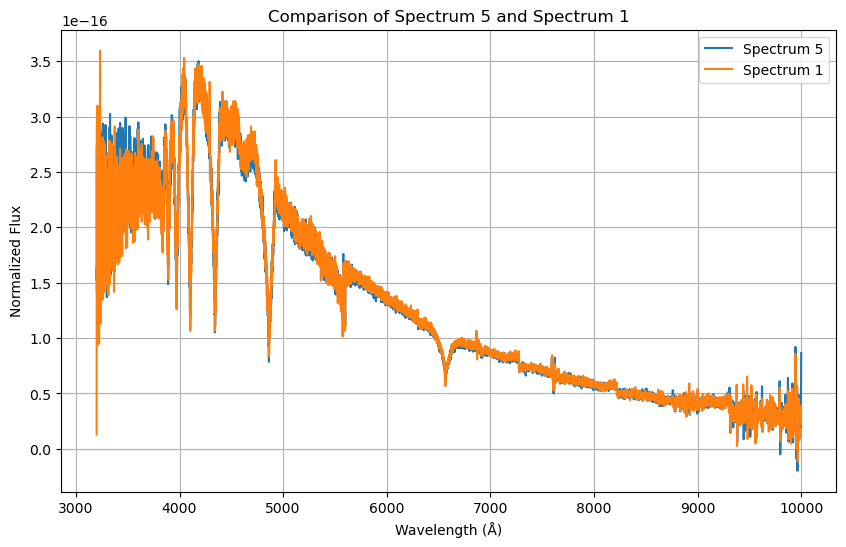

In [30]:
i1 = 5   # first spectrum
i2 = 1   # another spectrum

spec1 = spectra[i1]
spec2 = spectra[i2]

plt.figure(figsize=(10,6))
plt.plot(spec1.spectral_axis, spec1.flux, label=f"Spectrum {i1}")
plt.plot(spec2.spectral_axis, spec2.flux, label=f"Spectrum {i2}")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title(f"Comparison of Spectrum {i1} and Spectrum {i2}")
plt.grid(True)
plt.show()

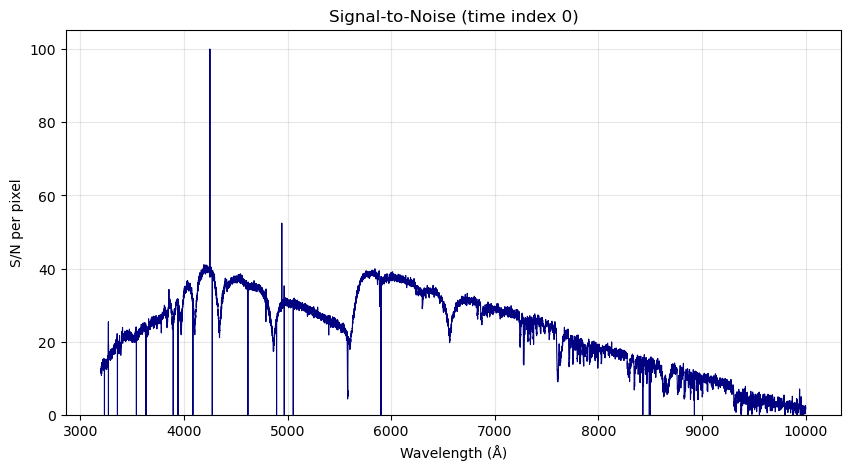

In [31]:
# Load dataset
ds = xr.open_dataset("D:/Pavlicek, Emma/SDSS1411/SDSS1411_spectra.nc")

wavelength = ds["wavelength"].values
flux = ds["flux_calibrated"].values          # shape (time, wavelength)
flux_err = ds["flux_calibrated_error"].values

# Compute S/N
snr = np.where(flux_err > 0, flux / flux_err, np.nan)   # shape (time, wavelength)

# Example: plot S/N for the first time index
plt.figure(figsize=(10,5))
plt.plot(wavelength, snr[0], lw=0.8, color="navy")
plt.xlabel("Wavelength (Å)")
plt.ylabel("S/N per pixel")
plt.title("Signal-to-Noise (time index 0)")
plt.grid(alpha=0.3)
plt.ylim(bottom=0)
plt.show()

plt.show()
